In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import seaborn as sns
from scipy.stats import norm
%matplotlib notebook

## Create a hitmap that is 20*20

In [2]:
def get_gaussian_weights(value, stds):
    
    '''
    return the weights for the time, longitude, and latitude for interpolation
    Uses the Gaussian distribution 
    
    param: values = list with [longitude, latitude, time] of that point
    param: stds = list with custom stds for [time, lon, lat]
    '''
    
    lon, lat, time = tuple(value)
    lon_std, lat_std, time_std = tuple(stds)
    
    
    # finds the weights
    w_time = norm.pdf(df['secDay'], loc=time, scale=time_std)
    w_lon = norm.pdf(df['Lon'], loc=lon, scale=lon_std)
    w_lat = norm.pdf(df['Lat'], loc=lat, scale=lat_std)
    
    return w_lon, w_lat, w_time

In [3]:
def get_data_for_heatmap(lons, lats, time, dists, heatmap_size, col_name='sw pCO2 (uatm)', scale_factor=1):
    
    dist_lon, dist_lat, dist_time = tuple(dists) 
    stds=[dist_lon * scale_factor, dist_lat * scale_factor, dist_time * scale_factor]

    data = np.zeros((heatmap_size, heatmap_size))
    for i, lat in enumerate(lats):
        
        data_arr = []
        
        for lon in lons:
            w_lon, w_lat, w_time = get_gaussian_weights((lon, lat, time), stds=stds)
            
            X = df[col_name].values
            val = np.sum(X * w_time * w_lon * w_lat) / np.sum(w_time * w_lon * w_lat)            
            data_arr.append(val)
        
        data[i, :] = data_arr
        
    return data

# Displaying timeseries heatmap

In [6]:
df = pd.read_csv('FLO_L3_20170317.csv', skiprows=[1])

# filters out all the values that are -9999
df.replace(-9999, np.NaN, inplace=True)
df = df[['Lat', 'Lon', 'secDay', 'Water temp (C)', 'Salinity (PSU)', 'O2 umol/L', 'Chl a (mg/m3)', 'sw pCO2 (uatm)']]
df.dropna(inplace=True)


heatmap_size = 20
# np.linspace(0, 7, 14, endpoint=False)[1::2]
time_size = 12
size_factor = 2
time_factor = 4

# calculates the distance of each box of the heatmap in lat/lon units
dist_lon = size_factor*(df['Lon'].max() - df['Lon'].min()) / heatmap_size
dist_lat = size_factor*(df['Lat'].max() - df['Lat'].min()) / heatmap_size
dist_time = time_factor*(df['secDay'].max() - df['secDay'].min()) / time_size

# gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
times = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size * 2, endpoint=False)[1::2]



<IPython.core.display.Javascript object>


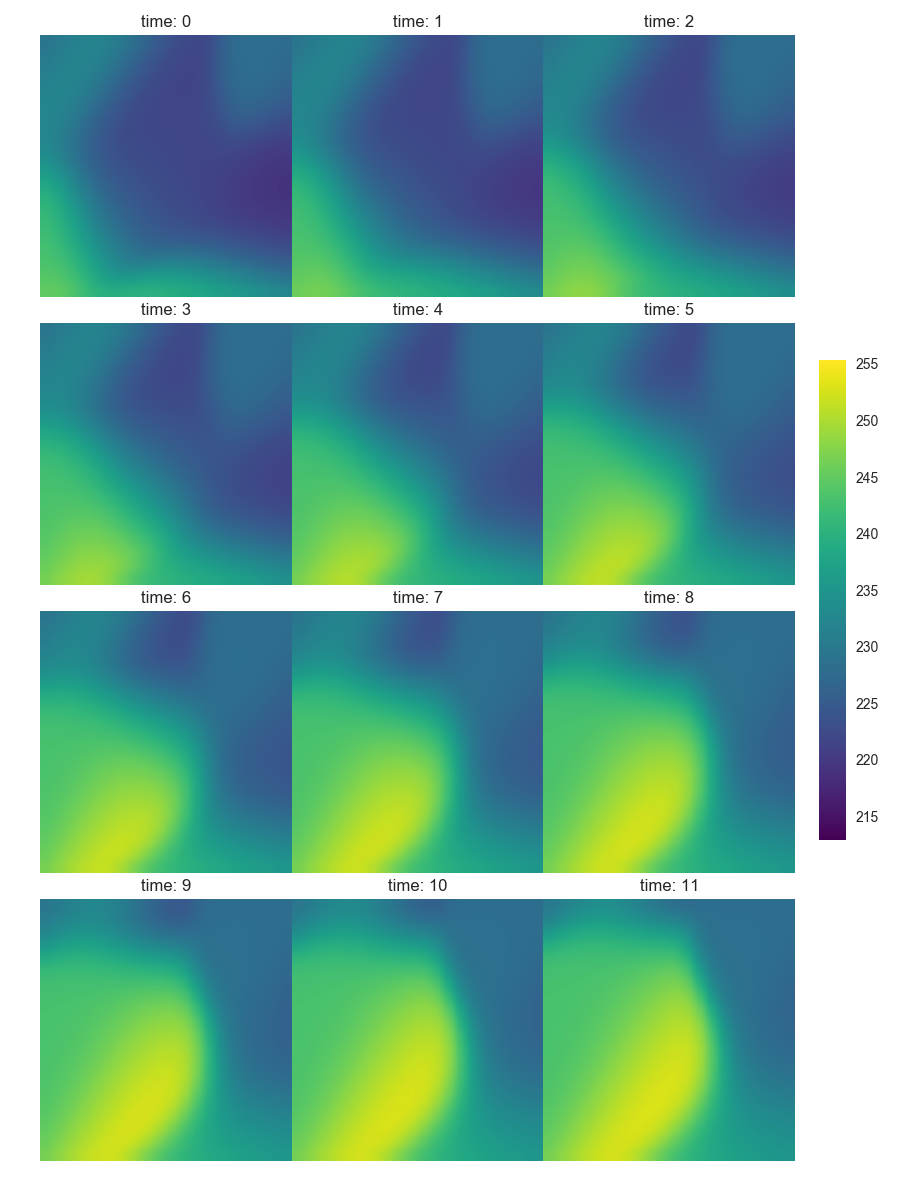

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [20]:
fig, axes = plt.subplots(4,3, figsize=(9, 12))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
# plt.subplots_adjust(wspace=0, hspace=0)
for i, ax in enumerate(axes.flat):
    data_arr = get_data_for_heatmap(lons, lats, times[i], 
                                    (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, scale_factor=1)
    im = ax.imshow(data_arr, 
                   cmap='viridis', 
                   vmin = df['sw pCO2 (uatm)'].min(),
                   vmax = df['sw pCO2 (uatm)'].max(),
                   origin='lower',
                   interpolation='gaussian')
    ax.set(title='time: {}'.format(i))
    ax.set_aspect('auto')
#     ax.invert_yaxis()
    ax.axis('off')
#     plt.tight_layout()

fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0.1)